# ***Progetto CV&DL - Alex Giacomini & Denis Bernovschi***

## IMPORT

In [1]:
import sys
import subprocess
if 'google.colab' in sys.modules:
  subprocess.call("pip install -U progress".split())

import pandas as pd
import random
import os
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision, torch 
import torch.nn as nn
import torchvision as tv
from PIL import Image
from torchvision import transforms, datasets, utils 
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torch import optim 
from torch.optim import Adam, SGD, RMSprop 
from PIL import Image, ImageOps
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

!pip install pytorch-lightning -q 
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer

#--- LINK UTILE PER EARLY STOPPING : https://github.com/Bjarten/early-stopping-pytorch
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from tensorflow.keras.models import Sequential, save_model, load_model

import matplotlib.pyplot as plt
import cv2
from random import randrange
random.seed( 40 )

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

#LINK UTILE : https://github.com/chongwar/vgg16-pytorch/blob/master/vgg16_transfer_learning.py
#LINK UTILE : https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/ 

from torchsummary import summary

import torch
is_torchvision_installed = True
try:
    import torchvision
except:
    is_torchvision_installed = False
import torch.utils.data
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

     |████████████████████████████████| 585 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 
     |████████████████████████████████| 140 kB 75.7 MB/s 
     |████████████████████████████████| 418 kB 79.5 MB/s 
     |████████████████████████████████| 1.1 MB 73.8 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 144 kB 76.3 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 


## Custom TO CATEGORICAL

In [2]:
#from tensorflow.keras.utils import to_categorical 
# LINK UTILE : https://pytorch.org/docs/stable/distributions.html
def custom_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

## DRIVE 

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

Mounted at /content/drive


## Parametri Immagini 

In [4]:
'''DEFINE VARIABLES AND PARAMETERS TO COLLECT THE INFORMATIONS FROM GOOGLE DRIVE'''
'''define a path for the collection of informations (CSV file) for the creation of the dataframe'''
os.chdir('/content/drive/MyDrive/ProgettoDL/') 

'''to have always the same sequence of randomized values (numbers)'''
random_state = 3  

'''some useful parameters and variables'''
parte = 'CALCIO'
tipo = 'NOCROP'
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

'''series of production & quality classes of the wood rifle butt'''
#classi = ['1','2','3','4']    
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']          
serie = [2,4,8,10,6,9,3,11,12,13,14,15,7] 

'''size of the images & their paths (location) '''
immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)
path_imgs = os.path.join(path_drive+'{}'.format(immgs))

#CSV loading (reading annotations/attributes/informations)
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")


#check if we're working with coloured or gray images
#if 'gray' in tipo:
#  colormode = "grayscale"
#  print('analisi in scala di grigi')
#else:
#  colormode = "rgb"
#'''

## SPLIT DATA

In [5]:
'''CUSTOM SPLIT DATA INTO TRAIN/TEST/VALIDATION SETS'''
"""
NOTE
- VERSIONE CON NUMERI PRESI DIRETTAMENTE DAL BILANCIAMENTO CALCOLATO RISPETTO IL TOTALE DI 2120 (che ci sono in questo progetto), PER RENDERLO DINAMICO CALCOLARE PESI IN MODO AUTOMATICO (STUDIA ALTERNATIVA)
- UNICO PROBLEMA È CHE A VOLTE IMMAGINI CON STESSO ID HANNO IN REALTÀ DIVERSA CLASSE DI QUALITÀ, QUINDI I DATASET NON SONO PERFETTAMENTE BILANCIATI MA VARIANO LEGGERMENTE,
(perchè lo stesso ID deve stare in stesso set anche se i lati del calcio del fucile possono avere qualità differente)
"""

'''split method'''
def split_data(dataframe_result, val_size, test_size, random_state):
  #n_ immagini per ciascuna classe di qualità
  classes_count = dataframe_result.groupby(['class']).size() 
  #data = vettore di immagini rappresentate da matrici numeriche a 3 colonne - dovrebbe diventare una data frame 
  #label = vettore da 3 colonne con componenti viste in funzione preprocessing sopra
  #val_size = 0.2 scelta nel codice
  #test_size = 0.2 scelta nel codice
  #random_state = 3 (parametro impostato nel codice)

  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)   #conto quanti ID univoci esistono nel dataset e li raccolgo tutti in vettore

  '''randomizing the order of the IDs, (to change the sequence change the random_state)'''
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  #print('ID Perm : {}'.format(id_perm))

               
  '''define finals sub-sets of data'''
  column_names = ['ID','series','filename','class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

  '''define variables to count elements inside the sub-sets'''
  conta, conta0, conta1, conta2, conta3, conta4, conta5, conta6, conta7, conta8, conta9 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  class_ = 0

  """
  alternatives of programming methods

  #test_size = int(test_size*len(id_perm))   
  ##print('Test Size : {}'.format(test_size))                            
  #val_size = int(val_size*len(id_perm))   
  ##print('Val Size : {}'.format(val_size)) 


  #SPLIT INTO DATAFRAME 
  #test_id = id_perm[:test_size]                                         #tutti gli elementi fino al numero che corrisponde a 'test_size' del vettore id_perm che avevo permutato sopra
  #val_id = id_perm[test_size:(test_size+val_size)]                      #tutti gli elementi da indice 'test_size' fino alla somma di quelli scritti
  #train_id = id_perm[(test_size+val_size):]                             #tutti gli elementi da indice indicato, fino alla fine
  #print('TEST ID : {}'.format(test_id))  
  #print('VAL ID : {}'.format(val_id))  
  #print('TRAIN ID : {}'.format(train_id))                    
  """  


  '''performing cycles to divide the images into the 3 sub-sets'''
  for i in id_perm:
     result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
      #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
     if result_ID[result_ID.columns[0]].count() == 2:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       row_2=result_ID.iloc[1]
       class2_ = int(row_2['class'])
       conta = 2
       #print("ID doppio")
     else:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       conta = 1
       #print("ID singolo")

     if class_ == 0 and conta0 < int((classes_count[0]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 < int((classes_count[1]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 < int((classes_count[2]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 < int((classes_count[3]/100)*60) :
        if conta == 2 :
          x_train=x_train.append(row_1, ignore_index=True) 
          x_train=x_train.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_train=x_train.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 < int((classes_count[4]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 < int((classes_count[5]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 < int((classes_count[6]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 < int((classes_count[7]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 < int((classes_count[8]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 < int((classes_count[9]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*60) and conta0 < int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*60) and conta1 < int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*60) and conta2 < int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*60) and conta3 < int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_val=x_val.append(row_1, ignore_index=True) 
          x_val=x_val.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_val=x_val.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*60) and conta4 < int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*60) and conta5 < int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*60) and conta6 < int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*60) and conta7 < int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*60) and conta8 < int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*60) and conta9 < int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_test=x_test.append(row_1, ignore_index=True) 
          x_test=x_test.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_test=x_test.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1

    
  return x_train, x_test, x_val

'''
#QUESTA VERSIONE SOTTO DIVIDE BENE PER ID, MA NON FA UNO SPLIT BILANCIATO PER CLASSI DI QUALITA'
#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte
 
  for i in test_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_test=x_test.append(row_1, ignore_index=True) 
    x_test=x_test.append(row_2, ignore_index=True)
  
  for i in val_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_val=x_val.append(row_1, ignore_index=True) 
    x_val=x_val.append(row_2, ignore_index=True)
  
  for i in train_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    row_1=result_ID.iloc[0]
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_train=x_train.append(row_1, ignore_index=True) 
    x_train=x_train.append(row_2, ignore_index=True)
'''

"\n#QUESTA VERSIONE SOTTO DIVIDE BENE PER ID, MA NON FA UNO SPLIT BILANCIATO PER CLASSI DI QUALITA'\n#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte\n \n  for i in test_id:                                                     \n    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]\n    #print(type(result_ID))\n    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))\n    row_1=result_ID.iloc[0]\n    row_2=result_ID.iloc[1]\n    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))\n    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))\n    x_test=x_test.append(row_1, ignore_index=True) \n    x_test=x_test.append(row_2, ignore_index=True)\n  \n  for i in val_id:                                                     \n    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]\n    #print(type(result_ID))\n    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))\n   

## CUSTOM DATASET

In [6]:
from skimage import io
class CustomDataset(Dataset):
  def __init__ (self, dataframe, transform=None, weight=None):
    self.transform = transform
    self.weight = weight
    self.dataframe = dataframe
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, index):
    #print(self.dataframe[1])
    #print("index")
    #print(index)
    path = self.dataframe.iloc[index, 2]
    img_path = os.path.join('/content/drive/MyDrive/CALCIO_NOPRE/'+path)
    image = io.imread(img_path)
    #print(image)
    y_label_class = torch.tensor(int(self.dataframe.iloc[index, 3]))              #iloc POTREBBE CREARE PROBLEMI EVENTUALMENTE USARE IN QUESTO MODO:     Y_lab_series = np.append(Y_lab_series,int(train_c_dataset.dataframe['series'][i]))
    y_label_series = torch.tensor(int(self.dataframe.iloc[index, 1]))
    #print("label_series")
    #print(self.dataframe.iloc[index, 1])
    #print(y_label_series)
    #print("--------------------------------------------------------------------")

    if self.transform:
      image = self.transform(image)

    return (image, y_label_class, y_label_series)



## Vecchia roba

In [7]:
    '''
    def __init__(self, df,
                 batch_size,  
                 X_col=None, y_col=None, 
                 input_size = (270, 470)):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        self.input_size = input_size

    def __len__(self):
        return len(self.df)

    def __get_input(self, path, target_size):
      transform = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.CenterCrop(0.75 * 64),
        transforms.Resize((470, 270)),
        #T.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
      
      #img = transform(path)
      #if(class) #--- if data weight applico un trasform 
      img = cv2.imread(path)
      img = cv2.resize(img, self.input_size)
      return img
    def __get_output(self, label, num_classes):
        print('calcolo categorical')
        ctc = custom_to_categorical(label, num_classes=num_classes)
        print(ctc)
        print('calcolo categorical completo')
        return custom_to_categorical(label, num_classes=num_classes)

    def __get_data(self, batches):
      # Generates data containing batch_size samples
      path_batch = batches[self.X_col['PATH_IMG']]  
      CLASSE_batch = batches[self.y_col['CLASSE']]
      X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])
      y_batch = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
      return X_batch, y_batch
    
    def __getitem__(self, index):
      batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
      X, y = self.__get_data(batches)
      return X, y 
'''

"\ndef __init__(self, df,\n             batch_size,  \n             X_col=None, y_col=None, \n             input_size = (270, 470)):\n    self.df = df.copy()\n    self.X_col = X_col\n    self.y_col = y_col\n    self.batch_size = batch_size\n    self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()\n    self.input_size = input_size\n\ndef __len__(self):\n    return len(self.df)\n\ndef __get_input(self, path, target_size):\n  transform = transforms.Compose([\n    transforms.ToPILImage(),\n    #transforms.CenterCrop(0.75 * 64),\n    transforms.Resize((470, 270)),\n    #T.RandomResizedCrop(image_size),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor()])\n  \n  #img = transform(path)\n  #if(class) #--- if data weight applico un trasform \n  img = cv2.imread(path)\n  img = cv2.resize(img, self.input_size)\n  return img\ndef __get_output(self, label, num_classes):\n    print('calcolo categorical')\n    ctc = custom_to_categorical(label, num_classes=num_classes)\n    print(ctc)

## NETWORK 

### Custom Newtork 

In [8]:
"""
import torch.nn.functional as F

#https://github.com/jvanvugt/pytorch-domain-adaptation/blob/master/utils.py
class GradientReversalFunction(torch.autograd.Function):

    #Gradient Reversal Layer from:
    #Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    #Forward pass is the identity function. In the backward pass,
    #the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

#first attempt - maybe function
class GradientReverse(torch.autograd.Function):
    scale = 1.0
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return GradientReverse.scale * grad_output.neg()
    
def grad_reverse(x, scale=1.0):
    GradientReverse.scale = scale
    return GradientReverse.apply(x)

"""

'\nimport torch.nn.functional as F\n\n#https://github.com/jvanvugt/pytorch-domain-adaptation/blob/master/utils.py\nclass GradientReversalFunction(torch.autograd.Function):\n\n    #Gradient Reversal Layer from:\n    #Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)\n    #Forward pass is the identity function. In the backward pass,\n    #the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)\n\n    @staticmethod\n    def forward(ctx, x, lambda_):\n        ctx.lambda_ = lambda_\n        return x.clone()\n\n    @staticmethod\n    def backward(ctx, grads):\n        lambda_ = ctx.lambda_\n        lambda_ = grads.new_tensor(lambda_)\n        dx = -lambda_ * grads\n        return dx, None\n\n#first attempt - maybe function\nclass GradientReverse(torch.autograd.Function):\n    scale = 1.0\n    @staticmethod\n    def forward(ctx, x):\n        return x.view_as(x)\n\n    @staticmethod\n    def backward(ctx, grad_output):\n        return GradientReve

In [9]:
'''
#import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    
        #self.conv6_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.conv6_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.conv6_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten1 = nn.Flatten()
        self.dropOut = nn.Dropout(0.5)

        self.fc1 = nn.Linear(57344, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.BatchNorm = nn.BatchNorm1d(4096)
        #self.BatchNorm = nn.BatchNorm2d(4096)
        self.fc3 = nn.Linear(4096, 10)

        #Adversarial Layers
        self.dropOutAdv = nn.Dropout(0.5)
        self.fc1Adv = nn.Linear(57344, 4096)
        self.fc2Adv = nn.Linear(4096, 4096)
        self.BatchNormAdv = nn.BatchNorm1d(4096)
        #self.BatchNorm = nn.BatchNorm2d(4096)
        self.fc3Adv = nn.Linear(4096, 13)


    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        
        #x = x.reshape(x.shape[0], -1)

        top_model = self.flatten1(x)
        x = F.relu(self.dropOut(top_model))
           
        x = F.relu(self.fc1(x))
        x = F.dropout2d(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))

        x = F.relu(self.BatchNorm(x))
    
        x = F.relu(self.fc3(x))
        #Insert Adversarial Learning Ramification
        x2 = GradientReversalFunction.apply(top_model,1)        #QUI CI HO MESSO IL VALORE 1, PERCHE SENZA VA IN ERRORE, MA NON HO IDEA SE SIA GIUSTO.
       
        x2 = F.relu(self.dropOutAdv(x2))
           
        x2 = F.relu(self.fc1Adv(x2))
        x2 = F.dropout2d(x2, 0.5) #dropout was included to combat overfitting
        x2 = F.relu(self.fc2Adv(x2))

        x2 = F.relu(self.BatchNormAdv(x2))
    
        x2 = F.relu(self.fc3Adv(x2))
        return [x, x2]

'''


'\n#import torch.nn.functional as F\n\nclass VGG16(nn.Module):\n    def __init__(self):\n        super(VGG16, self).__init__()\n        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)\n        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)\n    \n        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)\n        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)\n    \n        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)\n        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)\n        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)\n    \n        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)\n        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)\n     

In [10]:
#secondo modello dove faccio la ramificazione
#model = keras.Model(vgg16_conv.input, x, name="quality_recognizer")

#PLOT DEL MODELLO COMPLETO RAMIFICATO
#tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
#LINK: https://medium.com/@tioluwaniaremu/vgg-16-a-simple-implementation-using-pytorch-7850be4d14a1

'''
model = VGG16()

model.conv1_1.weight.requires_grad = False
model.conv1_2.weight.requires_grad = False

model.conv2_1.weight.requires_grad = False
model.conv2_2.weight.requires_grad = False

model.conv3_1.weight.requires_grad = False
model.conv3_2.weight.requires_grad = False
model.conv3_3.weight.requires_grad = False

model.conv4_1.weight.requires_grad = False
model.conv4_2.weight.requires_grad = False
model.conv4_3.weight.requires_grad = False

model.conv5_1.weight.requires_grad = False
model.conv5_2.weight.requires_grad = False
#model.conv5_3.weight.requires_grad = False

model = model.to(device)


#LINK : https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
#for para in model.parameters():
#    para.requires_grad = False
    #print(para)


#model.conv1_1.weight.requires_grad = False
#print(model.conv1_1.weight[:-1])


#model.conv1_1.weight[:-1].parameters.requires_grad = False 

#for param in enumerate(model.parameters()):
#  param[:-1] = torch.zeros_like(param[:-1])#
   
    #print(param[:-1])
    #if i == 0:
    #    param.grad[:,1] = torch.zeros_like(param.grad[:,1])


print(model)
summary(model,input_size=(3, 270,470))

#Plot Model 
#%pip install -U git+https://github.com/waleedka/hiddenlayer.git@master
#import hiddenlayer as hl
#hl.build_graph(model, torch.zeros([3, 3, 270, 470]))
'''

'\nmodel = VGG16()\n\nmodel.conv1_1.weight.requires_grad = False\nmodel.conv1_2.weight.requires_grad = False\n\nmodel.conv2_1.weight.requires_grad = False\nmodel.conv2_2.weight.requires_grad = False\n\nmodel.conv3_1.weight.requires_grad = False\nmodel.conv3_2.weight.requires_grad = False\nmodel.conv3_3.weight.requires_grad = False\n\nmodel.conv4_1.weight.requires_grad = False\nmodel.conv4_2.weight.requires_grad = False\nmodel.conv4_3.weight.requires_grad = False\n\nmodel.conv5_1.weight.requires_grad = False\nmodel.conv5_2.weight.requires_grad = False\n#model.conv5_3.weight.requires_grad = False\n\nmodel = model.to(device)\n\n\n#LINK : https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6\n#for para in model.parameters():\n#    para.requires_grad = False\n    #print(para)\n\n\n#model.conv1_1.weight.requires_grad = False\n#print(model.conv1_1.weight[:-1])\n\n\n#model.conv1_1.weight[:-1].parameters.requires_grad = False \n\n#for param in enumerate(model.parameters()

### Network Pre Allenato

#### Classe per creare il parallelismo 
LINK [Link GitHUB](https://github.com/pytorch/pytorch/issues/36459) 

In [11]:
class Parallel_Git(nn.Module):
    r"""A parallel container.
    Modules will be added to it in the order they are passed in the constructor.
    Alternatively, an ordered dict of modules can also be passed in.

    To make it easier to understand, here is a small example::

        # Example of using Parallel (1 tipo)
        model = nn.Parallel(
                  nn.Conv2d(1,20,5),
                  nn.ReLU(),
                  nn.Conv2d(20,64,5),
                  nn.ReLU()
                )

        # Example of using Parallel with OrderedDict (2 tipo)
        model = nn.Parallel(OrderedDict([
                  ('conv1', nn.Conv2d(1,20,5)),
                  ('relu1', nn.ReLU()),
                  ('conv2', nn.Conv2d(20,64,5)),
                  ('relu2', nn.ReLU())
                ]))
    """

    def __init__(self, *args):
        super(Parallel_Git, self).__init__()
        if len(args) == 1 and isinstance(args[0], OrderedDict): #(2° tipo)
            for key, module in args[0].items(): #estrai i moduli dal dizionario  separa nome, layer 
                self.add_module(key, module)
        else:
            for idx, module in enumerate(args): #estrai i moduli da parallelizare dal 'array' 1° tipo
                self.add_module(str(idx), module)

    def _get_item_by_idx(self, iterator, idx):
        """Get the idx-th item of the iterator"""
        size = len(self)  #numero di moduli 
        idx = operator.index(idx) #indice modulo 
        if not -size <= idx < size:
            raise IndexError('index {} is out of range'.format(idx))
        idx %= size
        #islice(iterable, start, stop, step)  - 
        #This iterator selectively prints the values mentioned in its iterable container passed as an argument.
        return next(islice(iterator, idx, None)) 


    def __getitem__(self, idx):
        #The isinstance() function returns True if the specified object is of the specified type, otherwise False.
        if isinstance(idx, slice):
            return self.__class__(OrderedDict(list(self._modules.items())[idx])) # se è del 2° tipo
        else:
            return self._get_item_by_idx(self._modules.values(), idx) # se è del 1°tipo 

    def __setitem__(self, idx, module):
        key = self._get_item_by_idx(self._modules.keys(), idx) #set modulo tramite l'id  2
        return setattr(self, key, module)

    def __delitem__(self, idx):  #elimina l'elemento 
        if isinstance(idx, slice): # se è del 2°tipo
            for key in list(self._modules.keys())[idx]:
                delattr(self, key)
        else:
            key = self._get_item_by_idx(self._modules.keys(), idx) #se è del 1°tipo
            delattr(self, key)


    def __len__(self): #n° dei moduli 
        return len(self._modules)

    def __dir__(self):
        keys = super(Parallel_Git, self).__dir__()
        keys = [key for key in keys if not key.isdigit()]
        return keys

    def __iter__(self):
        return iter(self._modules.values())

    def forward(self, input):
        output = []
        for module in self:
            output.append(module(input))
        return tuple(output)


#--------------------------------------------------------------
''' 
#classe utilizzata in precedenza, funziona, ma non aggiunge i pesi nel summary

class Parallel (torch.nn.Module): 
  def __init__(self, *modules: torch.nn.Module):
    super().__init__()
    self.modules = modules
  def forward(self, inputs):
    output = []
    for module in self.modules:
      output.append(module(inputs))
    return tuple(output)
    #return [module(inputs) for module in self.modules] 
'''

' \n#classe utilizzata in precedenza, funziona, ma non aggiunge i pesi nel summary\n\nclass Parallel (torch.nn.Module): \n  def __init__(self, *modules: torch.nn.Module):\n    super().__init__()\n    self.modules = modules\n  def forward(self, inputs):\n    output = []\n    for module in self.modules:\n      output.append(module(inputs))\n    return tuple(output)\n    #return [module(inputs) for module in self.modules] \n'

#### Pre trained Model 

In [12]:
#modelX = VGG16() #Definizione del modello Custom 
model = models.vgg16(pretrained=True)

#print('Len Classifier {}'.format(len(model.classifier)))
#model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)])
#print(model.features) # stampa tutto il modello a valle del classificatore 
#print(model.classifier) # stampa tutto il classificatore 
model.avgpool = nn.Identity() #sostituisco l'avg pool con un layer identità 
#print(model.avgpool) #stampo quel layer per controllo 

''' 
Per il reverse gradient ... ho usato questo, perché andava 
bene nel classifier sotto, quello precedente bisogna verificarlo
'''
#RevGrad 
%pip install -U git+https://github.com/janfreyberg/pytorch-revgrad.git
from pytorch_revgrad import RevGrad

classifier_1 = nn.Sequential(
          nn.Flatten(),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.ReLU(),
          nn.Linear(in_features=57344, out_features=4096),
          nn.Dropout2d(0.5),
          nn.ReLU(),
          nn.Linear(4096, 4096), 
          nn.ReLU(),
          nn.BatchNorm1d(4096),
          nn.ReLU(),
          nn.Linear(4096, 10)
)

classifier_2 = nn.Sequential(
          nn.Flatten(),
          RevGrad(), #-------
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.ReLU(),
          nn.Linear(in_features=57344, out_features=4096),
          nn.Dropout2d(0.5),
          nn.ReLU(),
          nn.Linear(4096, 4096), 
          nn.ReLU(),
          nn.BatchNorm1d(4096),
          nn.ReLU(),
          nn.Linear(4096, 13)
)


model.classifier = Parallel_Git(classifier_1, classifier_2) 
#model.classifier = Parallel(classifier_1, classifier_2) #---classe precedente di parallelismo


#Freeze Weights Convolution Layer 
for name, layer in model.named_modules():
  #print(name)
  #conv layer 
  if name == 'features.0':
    layer.weight.requires_grad = False 
  if name == 'features.2': 
    layer.weight.requires_grad = False 
  if name == 'features.5':
    layer.weight.requires_grad = False 
  if name == 'features.7': 
    layer.weight.requires_grad = False 
  if name == 'features.10':
    layer.weight.requires_grad = False 
  if name == 'features.12': 
    layer.weight.requires_grad = False 
  if name == 'features.14':
    layer.weight.requires_grad = False 
  if name == 'features.17': 
    layer.weight.requires_grad = False 
  if name == 'features.19': 
    layer.weight.requires_grad = False
  if name == 'features.21':
    layer.weight.requires_grad = False 
  if name == 'features.24': 
    layer.weight.requires_grad = False 
  if name == 'features.26':
    layer.weight.requires_grad = False 



model = model.to(device)

summary(model,input_size=(3,270,470))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/janfreyberg/pytorch-revgrad.git to /tmp/pip-req-build-5mbzrp7u
  Running command git clone -q https://github.com/janfreyberg/pytorch-revgrad.git /tmp/pip-req-build-5mbzrp7u
  Installing build dependencies ... done
  Getting requirements to build wheel ... done

  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pytorch-revgrad: filename=pytorch_revgrad-0.2.0-py3-none-any.whl size=4548 sha256=19bea34238714f5ebc5d9ded700ec97dec20789d571d3de22da45735ba288b44
  Stored in directory: /tmp/pip-ephem-wheel-cache-678gbttc/wheels/17/b8/be/fb29ec79262d31e6c7ae6e66f8952b4ba787a7f8b2fdf60b9e
Successfully built pytorch-revgrad
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 270, 470]           1,792
        

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [41]:
import hiddenlayer as hl
transforms = [ hl.transforms.Prune('Constant'), 
              hl.transforms.Fold("Conv > Relu", "Conv3x3Relu"),
              hl.transforms.Fold("Flatten > Flatten", "Flatten"),
              hl.transforms.Fold("Relu > Linear", "LinearRelu")
              ] # Removes Constant nodes from graph.
graph = hl.build_graph(model, torch.zeros([3, 3, 270, 470]), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('model_adversarial', format='png')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1672: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:258: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX

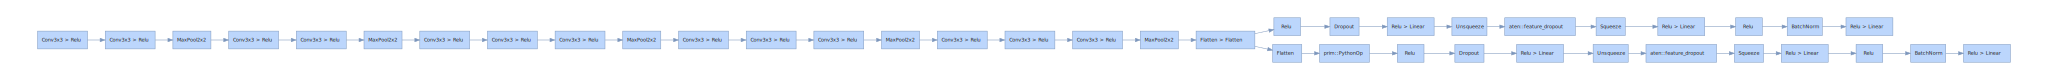

In [42]:
graph

In [17]:
from torchsummary import summary
summary(model,input_size=(3,270,470))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 270, 470]           1,792
              ReLU-2         [-1, 64, 270, 470]               0
            Conv2d-3         [-1, 64, 270, 470]          36,928
              ReLU-4         [-1, 64, 270, 470]               0
         MaxPool2d-5         [-1, 64, 135, 235]               0
            Conv2d-6        [-1, 128, 135, 235]          73,856
              ReLU-7        [-1, 128, 135, 235]               0
            Conv2d-8        [-1, 128, 135, 235]         147,584
              ReLU-9        [-1, 128, 135, 235]               0
        MaxPool2d-10         [-1, 128, 67, 117]               0
           Conv2d-11         [-1, 256, 67, 117]         295,168
             ReLU-12         [-1, 256, 67, 117]               0
           Conv2d-13         [-1, 256, 67, 117]         590,080
             ReLU-14         [-1, 256, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


## Metrica Balance Accuracy 

In [ ]:
import keras.backend as K
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
'''
Funzione per Balance Accuracy 
-- Link Utile : https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd --
-- https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05 --- 
-- https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score --- 
'''

'''
---- Questo caso funzione solo nel caso di classificazioni binarie ---- 
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		fn = K.sum(K.round(K.clip(y_true, 0, 1)))
		#sensitivity = tp / (fn + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule
		sensitivity = tp / (fn + tp + K.epsilon()) #--OK

		tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
		fp = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
		#specificity = tn / (fp + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule 
		specificity = tn / (fp + tn + K.epsilon()) #--OK 
	
		Balanced_Accuracy = (sensitivity+specificity)/2 #--OK
		return Balanced_Accuracy 
	return bal_acc
'''
		
'''
Funzione per Balance Accuracy 
'''
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		y_true = y_true.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		y_pred = y_pred.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
		Balanced_Accuracy = torch.tensor(Balanced_Accuracy) ##-- va trasformata in tensore (torch.tensor)
		return (Balanced_Accuracy) #--- capire se si può togliere il K. 
	return bal_acc

def _bal_acc_(y_true, y_pred, n_classes):
	y_true = y_true.detach().numpy()
	y_pred = y_pred.detach().numpy()
#	print(y_pred)
#	print(len(y_pred))
#	print(type(y_pred))
#	print(y_true)
#	print(len(y_true))
#	print(type(y_true))
#	print('categorical')
	y_true = custom_to_categorical(y_true,n_classes)
 
	y_true = y_true.argmax(axis=1) #Returns the indices of the maximum values along an axis.
	y_pred = y_pred.argmax(axis=1) #Returns the indices of the maximum values along an axis.
	Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
	Balanced_Accuracy = torch.tensor(Balanced_Accuracy) ##-- va trasformata in tensore (torch.tensor)
	return (Balanced_Accuracy) 

## Early Stopping Class

In [ ]:
import numpy as np
import torch

class _EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:      #con Val_loss (fuction e non attributo) ci va invece il <
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Val Bal Accuracy Increase ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## PREPROCESSING & DATA FRAME 

In [ ]:
'''PREPROCESSING PHASE OF THE DATAFRAME (CREATIONS OF THE SUBSETS TRAIN/VALIDATION/TEST, CALCULATE WEIGHTS OF ELEMENTS OF THE SUBSETS, VERIFY THAT SAME IDs ARE IN THE SAME SUBSET)'''
#from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from pandas.compat._optional import import_optional_dependency


os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()


'''reading inforamtions from the CSV'''
col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


'''rename the dataframe columns'''
dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

frames = [dataframe_sx, dataframe_dx] 
result = pd.concat(frames) #concatenate the two dataframes

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME COMPLETO INIZIALE")
print("result")
print(result)

#print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
#print("STAMPO ELEMENTO/I CON INDICE 1 (elemento tutto a sinistra)")
#print(result.loc[[1]])
#print(type(result.loc[[1]]))    #STAMPO IL TIPO DELL'ELEMENTO 

#print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
#print("LUNGHEZZA DATAFRAME COMPLESSIVO : {} ".format(result[result.columns[0]].count()))


'''mapping the values used for the classification into integer values'''
#version with 10 classes
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)}) 


'''identification of NULL values that would bring the execution on failing and eliminate those values'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Number of Null values in column 'quality_classes' : "+format(result['class'].isnull().sum()))
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
#print(result.loc[result['class'] == '0'])
print("mostro quegli elementi che hanno valore nullo")
print(result[result['class'].isnull()])
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

'''Remove Null elements to avoid failures during executions (data in not useful!)'''
print("Rimuovo gli elementi nulli e verifico stampando nuovamente i valori nulli:")
result['class'] = pd.to_numeric(result['class'], errors='coerce')
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli

print("elementi nulli rimasti: "+format(result['class'].isnull().sum()))     #stampo per verifica se ci sono elementi nulli


'''verify if images exist in the Google Drive folder, when not present it is eliminated from the dataset aswell'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("elimino i file che non sono presenti in Google Drive anche se ci sono nel CSV")
print('CHECK FILE NON PRESENTI NELLA CARTELLA')
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_NOPRE/')
i = 0; 
for index, row in result.iterrows():
    filename = row['filename']
    if os.path.exists('/content/drive/MyDrive/CALCIO_NOPRE/'+filename) == False:
      print('File Non Esiste !!!')
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))

print('CHECK FILE CON NaN')
print(result[result['class'].isnull()])
print(result[result['series'].isnull()])
print(result[result['filename'].isnull()])
print(result[result['ID'].isnull()])
result = result[result['class'].notna()]
result = result[result['series'].notna()]
result = result[result['filename'].notna()]
result = result[result['ID'].notna()]



#----PER FARE LE PROVE RIDUCO LA DIMENSIONE DI RESULTS#
#result = result[:,100]
#result = result[:500]


'''creation of masked images (grayscale images) and save them in Google Drive'''
'''than create a second dataframe with these new images'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
'''
mask_filenames = []
IDs = []
classes = []
for index, row in result.iterrows():
    filename = row['filename']
    mask_filenames.append(str("mask_"+filename))
    IDs.append(row['ID'])
    classes.append(row['class'])

print("DATAFRAME CON MASCHERE")
result2 = result.copy()
result2['mask_filename'] = mask_filenames
result2.drop('filename', axis='columns', inplace=True)   #rimuovo colonna con path immagini normali

column_names = ["ID","series", "mask_filename", "class"]
result2 = result2.reindex(columns=column_names)

print("result2")
print(result2)
#stampa della conta delle serie dei calci presenti nel dataframe
'''

'''performing the splitting of the dataframe into sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("SPLIT DATA")
train_balance_df, test_balance_df, val_balance_df  = split_data(result, 0.2, 0.2, 3)  #CUSTOM SPLIT CON ID IN STESSO SET DI DATI
#train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)           #split per test con immagini con maschere

print("train_balance_df")
print(train_balance_df)
print("test_balance_df")
print(test_balance_df)
print("val_balance_df")
print(val_balance_df)


#------------------------version with 4 classes (togliere se si lavora con 10 classi)-----------------------------------
#train_balance_df["class"] = train_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})
#val_balance_df["class"] = val_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})
#test_balance_df["class"] = test_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})

"""
NOTA: versione dei metodi di tensorflow, che non divide però mantenendo stessi ID in stessi Sub-set
train_balance_df, test_balance_df = train_test_split(result, test_size=0.4, stratify=result['class'], random_state=2)
test_balance_df, val_balance_df = train_test_split(test_balance_df, test_size=0.5, stratify=test_balance_df['class'],random_state=2)
"""

'''verify distibution of classes in the sub-sets and calculate weights of the classes in each sub-set'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
vals, counts = np.unique(train_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))

vals2, counts2 = np.unique(val_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Validation")
print(len(val_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts2[i]))

vals3, counts3 = np.unique(test_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Test")
print(len(test_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts3[i]))    





class_weights_train = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(train_balance_df['class']),y = train_balance_df['class'])
weight_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
print('Weight train_balance_df')
print(weight_train)


class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(val_balance_df['class']),y = val_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight val_balance_df')
print(weight)


class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(test_balance_df['class']),y = test_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight test_balance_df')
print(weight)


'''verify that same IDs are in the same sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")

'''method for univoque sets'''
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) >= 1 # boolean (true if there is at least 1 patient in both groups)
        
    return leakage


#--------verifico che stessi ID siano in stesso set--------
print("test case 1 - train VS validation")
print(f"Stessi ID in set usati?: {check_for_leakage(train_balance_df, val_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 2 - train VS test")
print(f"Stessi ID in set usati ?: {check_for_leakage(train_balance_df, test_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 3 - validation VS test")
print(f"Stessi ID in set usati?: {check_for_leakage(val_balance_df, test_balance_df, 'ID')}")


------------------------------------------------------------------------------------------------------------------------------------------------------------
DATAFRAME COMPLETO INIZIALE
result
        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Null values in column 'quality_classes' : 2
- - - - - - - - - - - - - - - - 

In [ ]:
'''Verifica Classi Qualità per ogni Serie'''
print("Verifica Classi Qualità per ogni Serie")
result_x_ = result.groupby(['series','class']).size()
print(result_x_)
result_class = result.groupby(['class']).size()
print(result_class)
result_series = result.groupby(['series']).size()
print(result_series)

print('SOMMA IMG : {}'.format(result_class[0]+result_class[1]+result_class[2]+result_class[3]+result_class[4]+result_class[5]+result_class[6]+result_class[7]+result_class[8]+result_class[9]))
      

Verifica Classi Qualità per ogni Serie
series  class
0       5.0       24
        6.0       85
        7.0        9
        8.0        2
1       1.0       32
        2.0      149
        3.0       26
        4.0       14
        5.0        3
2       0.0        1
        4.0       11
        5.0      176
        6.0       12
3       0.0      151
        1.0       19
        2.0       18
        3.0        4
        4.0        7
        5.0       10
        6.0       13
        7.0        2
        9.0        2
4       5.0        1
        6.0       19
        7.0       99
        8.0      252
        9.0       59
5       2.0        1
        4.0        2
        5.0       33
        6.0       70
        7.0       12
        8.0        2
6       3.0       11
        4.0      141
        5.0       16
7       0.0        3
        1.0       79
        2.0       27
        3.0      105
        4.0        4
8       7.0        8
        8.0        2
        9.0       18
9       0.0       10
  

## Loss Function

In [ ]:
from keras import backend as K
class weighted_categorical_crossentropy(object):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        loss = weighted_categorical_crossentropy(weights).loss
        model.compile(loss=loss,optimizer='adam')
    """
    
    def __init__(self,weights):
        self.weights = K.variable(weights)
        
    def loss(self,y_true, y_pred): 
        # scale preds so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred)
        # clip
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        # calc
        
        loss = y_true*K.log(y_pred)*self.weights
        loss =-K.sum(loss,-1)
        return loss

## HYPERPARAMETERS


The **optimization algorithm** (or optimizer) is the main approach used today for training a machine learning model to minimize its error rate. There are *two metrics* to determine the efficacy of an optimizer: **speed of convergence** (the process of reaching a global optimum for gradient descent); and **generalization** (the model’s performance on new data)

***SGD*** : Stochastic Gradient Descent 

Parameters 
- Learning : learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. ... In setting a learning rate, there is a trade-off between the rate of convergence and overshooting
- Momentum : Momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging.
- Decay :  We then set our decay to be the learning rate divided by the total number of epochs we are training the network for (a common rule of thumb) ... lr = (lr_iniziale - (1.0/(1-decay*iterations)))
- Nesterov: Nesterov which is set to false by default. Nesterov momentum is a different version of the momentum method which has stronger theoretical converge guarantees for convex functions.

[1° LINK](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

[2° LINK](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/)


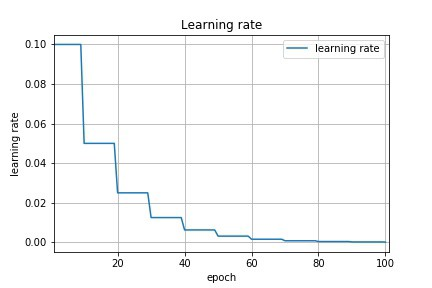

***ADAM*** :  Adaptive Moment Estimation




FONTI : Paper for ICLR 2019

In [ ]:
#Definizione hyperparameters                                                                                                                         #prova SGD
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
epochs = 5 #100 
bs = 32 #era 16 

losses = {
	"class_output": 'categorical_crossentropy', "series_output": 'categorical_crossentropy'
}
lossWeights = { "class_output": 1, "series_output":0.5}

## Creazione TrainDataset, ValDataset, TestDataset e il relativo DataLoader

In [ ]:
#https://github.com/galatolofederico/pytorch-balanced-batch/blob/master/example.py

class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)-1):
            label = self._get_label(dataset, idx)
            #print(label)
            if label not in self.dataset:
                print("LABEL ANCORA NON PRESENTE")   
                print(label)             
                self.dataset[label] = list()                          #se la label è nuova ne creo una lista vuota su cui per quella label devo arrivare al Numero di campioni della serie con numero che ne ha di più
                #print(self.dataset[label])
            self.dataset[label].append(idx)                           #memorizzo l'indice della label attuale pescata nella sua specifica lista
            #print(self.dataset[label])
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max          #per ricordarmi quanti sono i campioni massimi di una serie tra tutte le complessive
        
        #print("balnced_max")
        #print(self.balanced_max)              #osservo che il massimo rimane il numero di immagini per la serie che ne ha di più in partenza
        #print(len(self.dataset[label]))

        # Oversample the classes with fewer elements than the max.   - vado ad aggiungere a ciascuna lista di serie con meno elementi un augmentation per raggiungere una parità in numero di tutte le classi
        '''AGGIUNGERE QUA IL DATA-AUGMENTATION PER LE IMMAGINI CHE VENGONO RE-INSERITE PER PAREGGIARE IL NUMERO DELLE SERIE'''
        for label in self.dataset:
            #print("label in esame:")
            #print(label)
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))        #prendo un indice randomico di un immagine della stessa serie da inserire nuovamente
            #print("len")
            #print(len(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        #print(self.dataset[1])
        #print(self.keys)
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)
        #print(self.indices)                       #è un vettore di lunghezza N° series, con dentro tutti -1

    '''questo metodo si esegue quando si fa il training'''
    def __iter__(self):                                                             
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1    
            #print(self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]   )         #prendo l'elemento per una specifica serie, ad un certo indice, che rappresenterà l'indice in Y_lab vettore completo                                        
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]             #-------------Mantiene le prime TOT righe fino quando non termina il batch? - come un iteratore -------------
            self.currentkey = (self.currentkey + 1) % len(self.keys)                                  #permette di girare la chiave da 1->2->3->...->N°series
        self.indices = [-1]*len(self.keys)                                                            #riazzero il vettore degli indici per ripartire con il prossimo batch?
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:      
            #print(self.labels[idx].item())                     
            return self.labels[idx].item()
        else:
            # Trying guessing
            dataset_type = type(dataset)
            if is_torchvision_installed and dataset_type is torchvision.datasets.MNIST:
                return dataset.train_labels[idx].item()
            elif is_torchvision_installed and dataset_type is torchvision.datasets.ImageFolder:
                return dataset.imgs[idx][1]
            else:
                raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):                              #NON VIENE USATO
        return self.balanced_max*len(self.keys)

In [ ]:
_transform_ = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.CenterCrop(0.75 * 64),
        transforms.Resize((470, 270)),
        #T.RandomResizedCrop(image_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

train_c_dataset = CustomDataset(train_balance_df, transform=_transform_)
val_c_dataset = CustomDataset(val_balance_df, transform=_transform_)
test_c_dataset = CustomDataset(test_balance_df,transform=_transform_ )


Y_lab_series = []
#print(int(train_c_dataset.dataframe['series'][0]))
#print(int(train_balance_df.iloc[0, 1]))


for i in range (0,len(train_c_dataset.dataframe)):
  Y_lab_series = np.append(Y_lab_series,int(train_c_dataset.dataframe['series'][i]))
  #Y_lab_class = np.append(Y_lab_class,int(train_balance_df.iloc[i, 3]))


Y_lab_series = np.array(Y_lab_series)
#Y_lab_class = np.array(Y_lab_class)


print(np.count_nonzero(Y_lab_series == 0))
print(np.count_nonzero(Y_lab_series == 1))
print(np.count_nonzero(Y_lab_series == 2))
print(np.count_nonzero(Y_lab_series == 3))
print(np.count_nonzero(Y_lab_series == 4))


Y_lab_series_tens = torch.from_numpy(Y_lab_series)
#Y_lab_class_tens = torch.from_numpy(Y_lab_class)

print(Y_lab_series_tens)



'''forse c'è da mettere il sampler anche per il validation set '''
#SERVE DA INSERIRE AL BALANCEDBATCHSAMPLER IL TENSORE DELLE LABELS.
trainloader = torch.utils.data.DataLoader(dataset = train_c_dataset, sampler=BalancedBatchSampler(train_c_dataset,Y_lab_series_tens), batch_size=26, shuffle=False)#, shuffle=True) #default batch_size=bs, num_workers=2
#trainloader = torch.utils.data.DataLoader(dataset = train_c_dataset, batch_size=bs, shuffle=True) #default batch_size=bs, num_workers=2
valloader = torch.utils.data.DataLoader(dataset = val_c_dataset, batch_size=bs, shuffle=True)#,num_workers=2
testloader = torch.utils.data.DataLoader(dataset=test_c_dataset, batch_size=bs, shuffle=True)#,num_workers=2

78
152
122
122
256
tensor([ 4.,  4., 12.,  ...,  2., 12., 12.], dtype=torch.float64)
LABEL ANCORA NON PRESENTE
4.0
LABEL ANCORA NON PRESENTE
12.0
LABEL ANCORA NON PRESENTE
2.0
LABEL ANCORA NON PRESENTE
7.0
LABEL ANCORA NON PRESENTE
1.0
LABEL ANCORA NON PRESENTE
0.0
LABEL ANCORA NON PRESENTE
9.0
LABEL ANCORA NON PRESENTE
3.0
LABEL ANCORA NON PRESENTE
5.0
LABEL ANCORA NON PRESENTE
6.0
LABEL ANCORA NON PRESENTE
10.0
LABEL ANCORA NON PRESENTE
8.0
LABEL ANCORA NON PRESENTE
11.0
[12, 13, 76, 77, 90, 91, 92, 93, 100, 101, 108, 109, 110, 111, 114, 115, 132, 133, 136, 137, 160, 161, 196, 197, 220, 221, 222, 223, 226, 227, 230, 231, 242, 243, 252, 253, 314, 315, 324, 325, 328, 329, 342, 343, 368, 369, 372, 373, 380, 381, 398, 399, 404, 405, 430, 431, 432, 433, 434, 435, 436, 437, 448, 449, 458, 459, 474, 475, 488, 489, 506, 507, 540, 541, 542, 543, 546, 547, 554, 555, 582, 583, 596, 597, 606, 607, 626, 627, 634, 635, 664, 665, 668, 669, 670, 671, 696, 697, 700, 701, 702, 703, 704, 705, 734, 735,

## Testing Model

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import time

#per ignorare i vari warnings
import warnings
warnings.filterwarnings("ignore")

#LINK UTILE : https://stackoverflow.com/questions/59584457/pytorch-is-there-a-definitive-training-loop-similar-to-keras-fit
'''
LINK UTILE PER CREARE UN OGGETO DI CLASSE Trainer, CHE OTTIMIZZA IL PROCESSO DI TRAINING INCORPORANDO ANCHE LE CALLBACKS
https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer
'''

'''training a GAN'''
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

#https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

model.to(device)
criterion = nn.CrossEntropyLoss() #sarebbere la nostra loss function
optimizer = opt #opt definito all'interno del blocco Hyper-Parameters 


history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss_class'] = []
history['loss_series'] = []
history['val_loss_class'] = []
history['val_loss_series'] = []
history['acc_class'] = []
history['acc_series'] = []
history['val_acc_class'] = []
history['val_acc_series'] = []
history['bal_acc_class'] = []
history['bal_acc_series'] = []
history['val_bal_acc_class'] = []
history['val_bal_acc_series'] = []


start_time_sec = time.time()
losses_class = [] 
losses_series = [] 

early_stopping = _EarlyStopping(patience=5, verbose=True)

print('train() called: model={}, opt={}, epochs={}, device={}\n'.
      format(type(model).__name__,type(optimizer).__name__, epochs, device))

for epoch in range(0, epochs):
    #alleno il modello 
    model.train()
    train_loss_class = 0.0
    train_loss_series = 0.0
    num_train_correct_class  = 0
    num_train_examples_class = 0
    num_train_correct_series  = 0
    num_train_examples_series = 0
    
    for batch_idx, (data,targets, targets2) in enumerate(trainloader):
      data = data.to(device=device)
      targets = targets.to(device = device) #classes
      #print(targets)
      targets2 = targets2.to(device = device) #series
      #print("classes")
      #print(targets)
      #print("-----------------")
      #print("series")
      #print(targets2)
      #print("--------------------------------------------------------------------")

      scores = model(data)
      #print("-----------------")
      #print(torch.max(scores[0], 1)[1]) #per stampare le predizioni in formato label effettivo.
      #print("-----------------")
      #print(scores[1])
      loss_class = criterion(scores[0],targets)
      loss_series = criterion(scores[1],targets2)
      losses_class.append(loss_class.item())
      losses_series.append(loss_series.item())

      loss_tot = loss_class + loss_series  

      loss_tot.backward() 
      
      #'''senza parametro in ingresso non farebbe'''
      #loss_class.backward(retain_graph=True)    #parametro in ingresso --- senza non scorre due volte
      #loss_series.backward(retain_graph=True) #parametro in ingresso --- senza non scorre due volte
      #'''---------------------------------------'''
      optimizer.zero_grad() #---capire cosa fa ?
      optimizer.step()

      train_loss_class         += loss_class.data.item() * data.size(0)
      num_train_correct_class  += (torch.max(scores[0], 1)[1] == targets).sum().item()
      num_train_examples_class += data.shape[0]   
      bal_acc_class = _bal_acc_(targets,scores[0],10)

      train_loss_series         += loss_series.data.item() * data.size(0)
      num_train_correct_series  += (torch.max(scores[1], 1)[1] == targets2).sum().item()
      num_train_examples_series += data.shape[0]   
      bal_acc_series = _bal_acc_(targets2,scores[1],13)
    
    #print('num_train_correct {}'.format(num_train_correct))
    #print('num_train_examples {}'.format(num_train_examples))

    train_acc_class   = num_train_correct_class / num_train_examples_class
    train_loss_class  = train_loss_class / len(trainloader.dataset.dataframe)
    train_acc_series   = num_train_correct_series / num_train_examples_series
    train_loss_series  = train_loss_series / len(trainloader.dataset.dataframe)

    #bal_acc = _bal_acc_(targets,scores)
    print('Inizio Validation')
    model.eval()
    val_loss_class       = 0.0
    num_val_correct_class  = 0
    num_val_examples_class = 0
    val_loss_series       = 0.0
    num_val_correct_series  = 0
    num_val_examples_series = 0

    for batch_idx, (data,targets, targets2) in enumerate(valloader):
      data = data.to(device=device)
      targets = targets.to(device = device)
      targets2 = targets2.to(device = device)
 

      scores = model(data)
      loss_class = criterion(scores[0],targets)
      loss_series = criterion(scores[1],targets2)

      val_loss_class         += loss_class.data.item() * data.size(0)
      num_val_correct_class  += (torch.max(scores[0], 1)[1] == targets).sum().item()
      num_val_examples_class += scores[0].shape[0]

      val_loss_series         += loss_series.data.item() * data.size(0)
      num_val_correct_series  += (torch.max(scores[1], 1)[1] == targets2).sum().item()
      num_val_examples_series += scores[1].shape[0]
    
    #print('num_val_correct {}'.format(num_val_correct))
    #print('num_val_examples {}'.format(num_val_examples))
    val_acc_class  = num_val_correct_class / num_val_examples_class
    val_loss_class = val_loss_class / len(valloader.dataset.dataframe)
    val_bal_acc_class = _bal_acc_(targets,scores[0],10)

    val_acc_series  = num_val_correct_series / num_val_examples_series
    val_loss_series = val_loss_series / len(valloader.dataset.dataframe)
    val_bal_acc_series = _bal_acc_(targets2,scores[1],13)
    

    history['loss_class'].append(train_loss_class)
    history['val_loss_class'].append(val_loss_class)
    history['acc_class'].append(train_acc_class)
    history['val_acc_class'].append(val_acc_class)
    history['bal_acc_class'].append(bal_acc_class)
    history['val_bal_acc_class'].append(val_bal_acc_class)
    history['loss_series'].append(train_loss_series)
    history['val_loss_series'].append(val_loss_series)
    history['acc_series'].append(train_acc_series)
    history['val_acc_series'].append(val_acc_series)
    history['bal_acc_series'].append(bal_acc_series)
    history['val_bal_acc_series'].append(val_bal_acc_series)


    print('Epoch : {} di {}, train loss class : {} , train acc class : {}, val loss class: {}, val acc class: {}, bal acc class: {} , val bal acc class: {} ' . format(epoch+1,epochs, train_loss_class, train_acc_class, val_loss_class, val_acc_class, bal_acc_class, val_bal_acc_class ))
    print('Epoch : {} di {}, train loss series: {} , train acc series: {}, val loss series: {}, val acc series: {}, bal acc series: {} , val bal acc series: {} ' . format(epoch+1,epochs, train_loss_series, train_acc_series, val_loss_series, val_acc_series, bal_acc_series, val_bal_acc_series ))
   
    
    early_stopping(val_bal_acc_class, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break


end_time_sec = time.time()
total_time_sec = end_time_sec - start_time_sec
time_per_epoch_sec = total_time_sec / epochs
print('Time total:     %5.2f sec' % (total_time_sec))
print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))


train() called: model=VGG, opt=SGD, epochs=5, device=cpu

Inizio Validation
Epoch : 1 di 5, train loss class : 6.283950207184772 , train acc class : 0.1024639423076923, val loss class: 2.299891497851548, val acc class: 0.0971563981042654, bal acc class: 0.1392857142857143 , val bal acc class: 0.0 
Epoch : 1 di 5, train loss series: 7.048435838855043 , train acc series: 0.07542067307692307, val loss series: 2.575278701375446, val acc series: 0.06635071090047394, bal acc series: 0.038461538461538464 , val bal acc series: 0.0 
Val Bal Accuracy Increase (inf --> 0.000000).  Saving model ...
Inizio Validation
Epoch : 2 di 5, train loss class : 6.303882739981827 , train acc class : 0.0985576923076923, val loss class: 2.2990560497717833, val acc class: 0.1018957345971564, bal acc class: 0.08928571428571427 , val bal acc class: 0.125 
Epoch : 2 di 5, train loss series: 7.0417369871723405 , train acc series: 0.07241586538461539, val loss series: 2.578077550182975, val acc series: 0.059241706161

## PLOT 

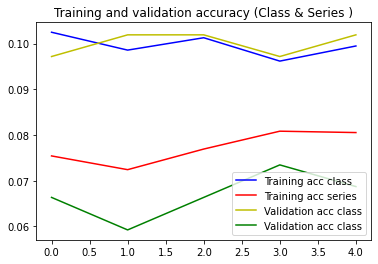

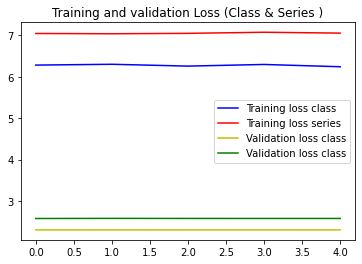

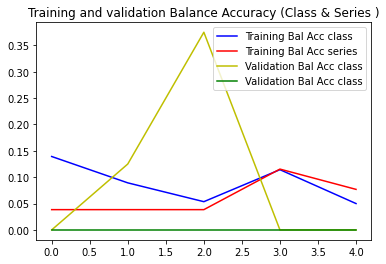

In [ ]:
'''PLOT CURVES'''

path = path_drive+'ProgettoDL/'

acc_class = history['acc_class']
acc_series = history['acc_series']
val_acc_class = history['val_acc_class']
val_acc_series = history['val_acc_series']

loss_class = history['loss_class']
loss_series = history['loss_series']
val_loss_class = history['val_loss_class']
val_loss_series = history['val_loss_series']

bal_acc_class = history['bal_acc_class']
bal_acc_series = history['bal_acc_series']
val_bal_acc_class = history['val_bal_acc_class']
val_bal_acc_series = history['val_bal_acc_series']

lista = [
       acc_class, acc_series, val_acc_class, val_acc_series, 
       loss_class, loss_series, val_loss_class, val_loss_series, 
       bal_acc_class, bal_acc_series, val_bal_acc_class, val_bal_acc_series
]


import csv

with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
len_epochs = range(len(acc_class))

plt.plot(len_epochs, acc_class, 'b', label='Training acc class')
plt.plot(len_epochs, acc_series, 'r', label='Training acc series')
plt.plot(len_epochs, val_acc_class, 'y', label='Validation acc class')
plt.plot(len_epochs, val_acc_series, 'g', label='Validation acc class')
plt.title('Training and validation accuracy (Class & Series )')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}.pdf'.format(immgs,cnn))) 
plt.figure()


plt.plot(len_epochs, loss_class, 'b', label='Training loss class')
plt.plot(len_epochs, loss_series, 'r', label='Training loss series')
plt.plot(len_epochs, val_loss_class, 'y', label='Validation loss class')
plt.plot(len_epochs, val_loss_series, 'g', label='Validation loss class')
plt.title('Training and validation Loss (Class & Series )')
plt.legend()
plt.savefig(os.path.join(path+'weights/Plot_Loss_Adversarial{}_{}.pdf')) 
plt.figure()


plt.plot(len_epochs, bal_acc_class, 'b', label='Training Bal Acc class')
plt.plot(len_epochs, bal_acc_series, 'r', label='Training Bal Acc series')
plt.plot(len_epochs, val_bal_acc_class, 'y', label='Validation Bal Acc class')
plt.plot(len_epochs, val_bal_acc_series, 'g', label='Validation Bal Acc class')
plt.title('Training and validation Balance Accuracy (Class & Series )')
plt.legend()
plt.savefig(os.path.join(path+'weights/Plot_Balance_Accuracy_Adversarial.pdf')) 

## SAVE MODEL 

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
#salvataggio modello pesi finali
path = path_drive+'ProgettoDL/pytorch_model'
torch.save(model.state_dict(), os.path.join(path))
print("Saved model to disk")

Saved model to disk


## LOAD MODEL 

In [ ]:
path = path_drive+'ProgettoDL/pytorch_model'
model.load_state_dict(torch.load(path))
model.eval()
print('Model IMG Loaded')


Model IMG Loaded


## PREDICTION 

In [ ]:
# evaluate the model
model.eval()
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for batch_idx, (data,targets, targets2) in enumerate(testloader):
        data = data.to(device=device)
        targets = targets.to(device = device)
        # evaluate the model on the test set
        yhat = model(data)
        # retrieve numpy array
        yhat = yhat[0].detach().numpy()
        actual = targets.numpy()
        actual_ = (custom_to_categorical(np.unique(actual, return_inverse=True)[1], num_classes=10))
        #actual = actual.reshape((len(actual), 1))
        # round to class values
        #yhat = np.argmax(yhat,axis=1)---> restituisce l'array con le label direttamente 
        # store
        #print('-----><-----')
        #print(actual.reshape((len(actual), 1)))
        #print(actual_)
        #print('-----><-----')
        predictions.append(yhat)
        actuals.append(actual_)
    return predictions, actuals

In [ ]:
y_pred_, y_test_ = evaluate_model(testloader, model)

In [ ]:
test_array = []
test_array_series = []

for index, row in test_balance_df.iterrows():
    class_ = int(row['class'])
    series_ = int(row['series'])          #---da qui e nei prossimi, calcolo la ground thruth del shotgun series, ovvero i semplici COD_COMPONENTE (serie) che appartengono al sub-set di test
    test_array.append(class_)
    test_array_series.append(series_)     #---

test_array = np.array(test_array)
test_array_series = np.array(test_array_series)   #---

num_class_ = len(np.unique(test_array))
print('Num Class : {}'.format(num_class_))

num_series_ = len(np.unique(test_array_series))
print('Num Series : {}'.format(num_series_))


y_test = custom_to_categorical(np.unique(test_array, return_inverse=True)[1],num_classes=num_class_)
y_test_series = custom_to_categorical(np.unique(test_array_series, return_inverse=True)[1],num_classes=num_series_)  

y_test_no_argmax = y_test
y_test = y_test.argmax(axis=1)

y_test_series = y_test_series.argmax(axis=1)      #---
y_pred = np.squeeze(np.concatenate( y_pred_, axis=0))
#---------------
#metriche nuove senza usare argmax.
#---------------
y_pred_no_argmax = y_pred
y_pred = np.squeeze(np.concatenate( y_pred_, axis=0)).argmax(axis=1)

print(y_pred.shape)
print(y_test.shape)

print(y_pred_no_argmax.shape)
print(y_test_no_argmax.shape)

Num Class : 10
Num Series : 13
(424,)
(424,)
(424, 10)
(424, 10)


##SEARCH UNIVOQUE SERIES TO BALANCE SETS

In [ ]:
#SEARCHING UNIVOQUE SERIES
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test_balance_df.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(y_test[i])
      pred_array_s0.append(y_pred[i])
    if series_ == 1:
      test_array_s1.append(y_test[i])
      pred_array_s1.append(y_pred[i])
    if series_ == 2:
      test_array_s2.append(y_test[i])
      pred_array_s2.append(y_pred[i])
    if series_ == 3:
      test_array_s3.append(y_test[i])
      pred_array_s3.append(y_pred[i])
    if series_ == 4:
      test_array_s4.append(y_test[i])
      pred_array_s4.append(y_pred[i])
    if series_ == 5:
      test_array_s5.append(y_test[i])
      pred_array_s5.append(y_pred[i])
    if series_ == 6:
      test_array_s6.append(y_test[i])
      pred_array_s6.append(y_pred[i])
    if series_ == 7:
      test_array_s7.append(y_test[i])
      pred_array_s7.append(y_pred[i])
    if series_ == 8:
      test_array_s8.append(y_test[i])
      pred_array_s8.append(y_pred[i])
    if series_ == 9:
      test_array_s9.append(y_test[i])
      pred_array_s9.append(y_pred[i])
    if series_ == 10:
      test_array_s10.append(y_test[i])
      pred_array_s10.append(y_pred[i])
    if series_ == 11:
      test_array_s11.append(y_test[i])
      pred_array_s11.append(y_pred[i])
    if series_ == 12:
      test_array_s12.append(y_test[i])
      pred_array_s12.append(y_pred[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

[7, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 6]
[2, 2, 4, 3, 5, 7, 1, 3, 8, 5, 2, 0, 6, 8, 7, 2, 1, 5, 6, 2, 5, 6, 2, 1, 3, 6]
[0 1 2 3 4 5 6 7 8]


## METRICHE MASK & IMG 

In [ ]:
'''METRICHE'''
print('--------------Metrice IMG----------------')

a = accuracy_score(y_test, y_pred)                                              # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("test accuracy:",a)
print("precision:", precision_score(y_test, y_pred , average="macro"))          # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("recall:", recall_score(y_test, y_pred , average="macro"))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score
print("f1_score:", f1_score(y_test, y_pred , average="macro"))                  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score

print('classification report:')
print(classification_report(y_test, y_pred))  



--------------Metrice IMG----------------
test accuracy: 0.09433962264150944
precision: 0.09617609423600479
recall: 0.09036654646875297
f1_score: 0.08819738344660834
classification report:
              precision    recall  f1-score   support

           0       0.13      0.14      0.13        37
           1       0.00      0.00      0.00        39
           2       0.08      0.16      0.10        38
           3       0.07      0.11      0.08        28
           4       0.27      0.17      0.21        35
           5       0.16      0.08      0.11        64
           6       0.11      0.14      0.13        69
           7       0.05      0.05      0.05        43
           8       0.10      0.06      0.08        48
           9       0.00      0.00      0.00        23

    accuracy                           0.09       424
   macro avg       0.10      0.09      0.09       424
weighted avg       0.10      0.09      0.09       424



Per quanto riguarda la funzione np_quadratic_weighted_kappa abbiamo avuto alcune difficoltà implementative e quindi abbiamo cercato un codice online che ci calcolasse la stessa metrica 

[Link Utilizzato](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

In [ ]:

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=1 # era None abbiamo messo 0
    max_rating=9 # era None abbiamo messo 9
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [ ]:
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)

from metrics import np_quadratic_weighted_kappa, minimum_sensitivity
from sklearn.metrics import mean_absolute_error

def compute_metrics(y_true, y_pred, num_classes):

  #run function minimum_sensitivity
  
  qwk = quadratic_weighted_kappa(y_true, y_pred)
  ms = minimum_sensitivity(y_test_no_argmax, y_pred_no_argmax)
  #per il mae ho seguito questo link : https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
  mae_loss = torch.nn.L1Loss()
  output = mae_loss(torch.Tensor(y_test_no_argmax),torch.Tensor(y_pred_no_argmax))
  mae = output
  
  metrics = {
		'QWK': qwk,
		'MS': ms,
		'MAE': mae}
  
  return metrics

def print_metrics(metrics):
	print('QWK: {:.4f}'.format(metrics['QWK']))
	print('MS: {:.4f}'.format(metrics['MS']))
	print('MAE: {:.4f}'.format(metrics['MAE']))    


#-----codice------

num_classi = 10
metrics = compute_metrics(y_test, y_pred,num_classi)
print_metrics(metrics)

with open("metrics.txt", "w") as text_file:
    print(print_metrics, file=text_file)





QWK: -0.0426
MS: 0.0000
MAE: 0.1561


***Metrice Ottenute***

**K Cohen**   https://it.vvikipedla.com/wiki/Cohen%27s_kappa
Il Kappa di Cohen è un coefficiente statistico che rappresenta il grado di accuratezza e affidabilità in una classificazione statistica; è un indice di concordanza che tiene conto della probabilità di concordanza casuale; l'indice calcolato in base al rapporto tra l'accordo in eccesso rispetto alla probabilità di concordanza casuale e l'eccesso massimo ottenibile. Attraverso la matrice di confusione è possibile valutare questo parametro. In particolare ... Esistono diversi "gradi di concordanza", in base ai quali possiamo definire se Kappa di Cohen è scarso o ottimo:

- se k assume valori inferiori a 0, allora non c'è concordanza;
- se k assume valori compresi tra 0-0,4, allora la concordanza è scarsa;
- se k assume valori compresi tra 0,4-0,6, allora la concordanza è discreta;
- se k assume valori compresi tra 0,6-0,8, la concordanza è buona;
- se k assume valori compresi tra 0,8-1, la concordanza è ottima.

**QWK**: 0.7849

BLA BLA BLA 

**MS**: 1.0000


In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 

**MAE**: 0.0000

## PLOT CONFUSION MATRIX FUNCTION 

In [ ]:
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX 

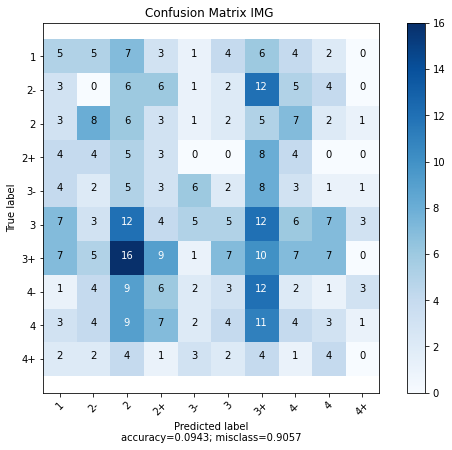

<Figure size 432x288 with 0 Axes>

In [ ]:
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix IMG ")
plt.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 




##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

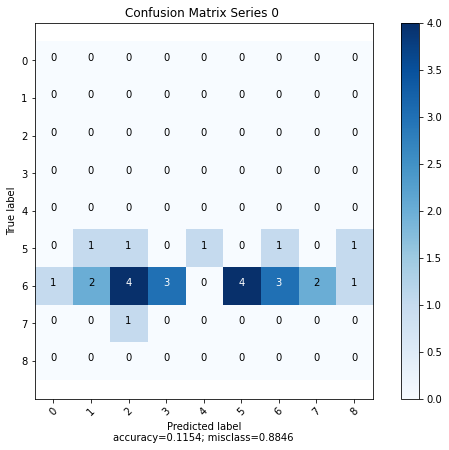

<Figure size 432x288 with 0 Axes>

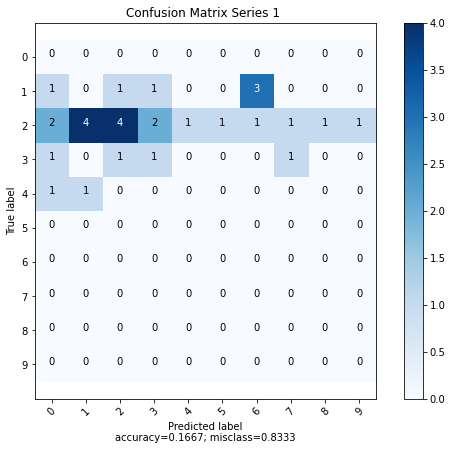

<Figure size 432x288 with 0 Axes>

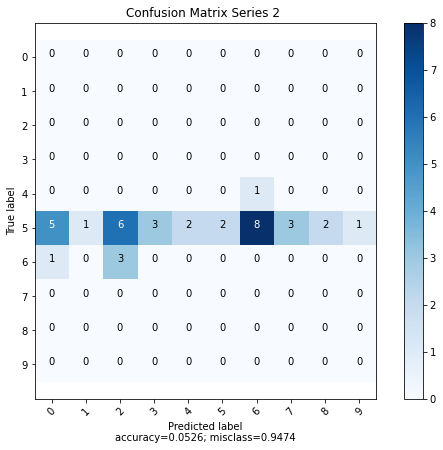

<Figure size 432x288 with 0 Axes>

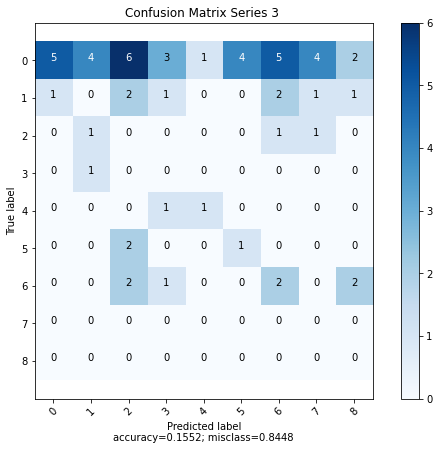

<Figure size 432x288 with 0 Axes>

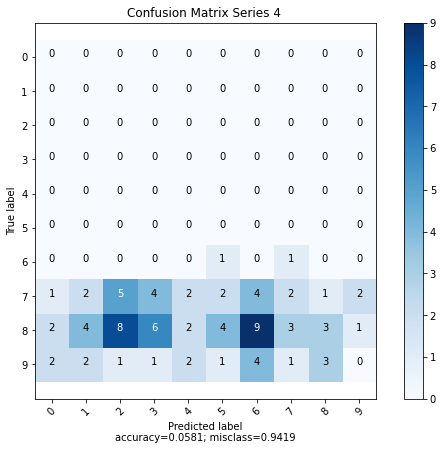

<Figure size 432x288 with 0 Axes>

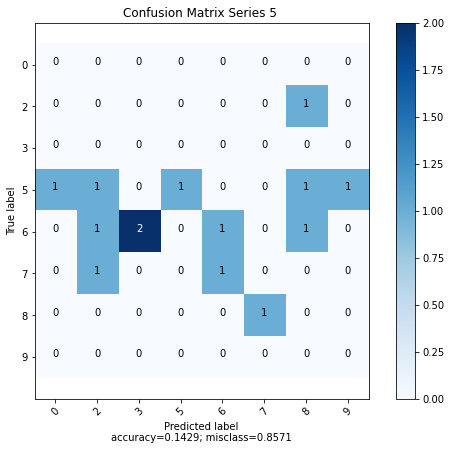

<Figure size 432x288 with 0 Axes>

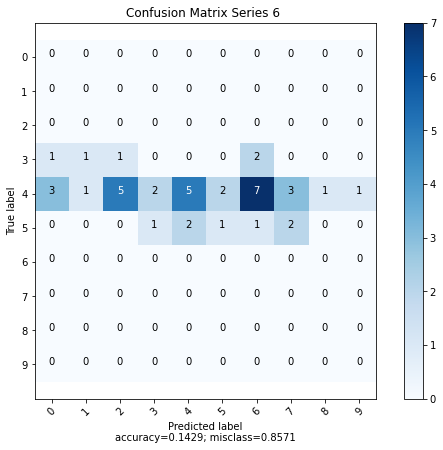

<Figure size 432x288 with 0 Axes>

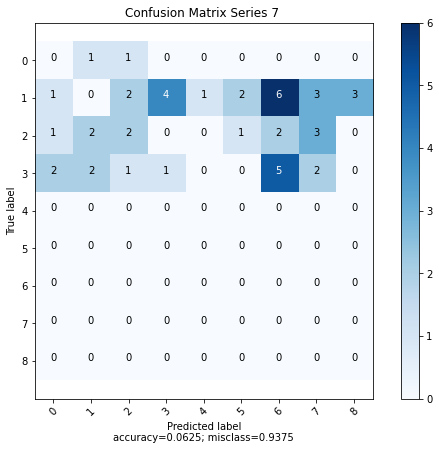

<Figure size 432x288 with 0 Axes>

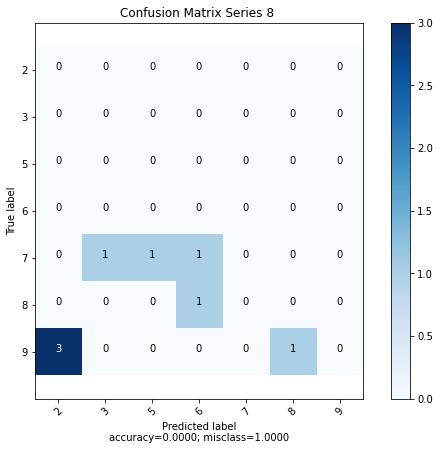

<Figure size 432x288 with 0 Axes>

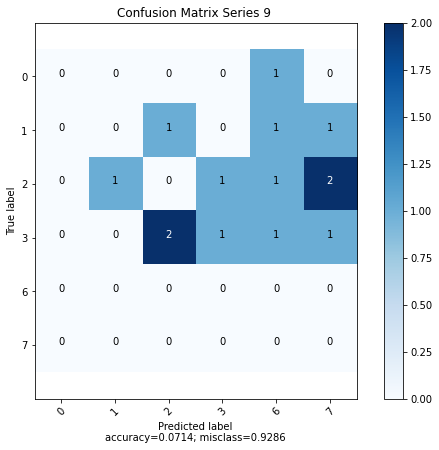

<Figure size 432x288 with 0 Axes>

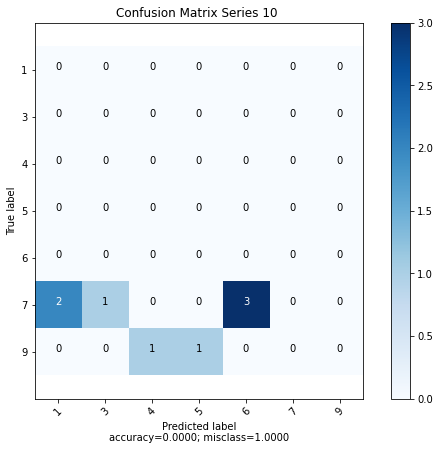

<Figure size 432x288 with 0 Axes>

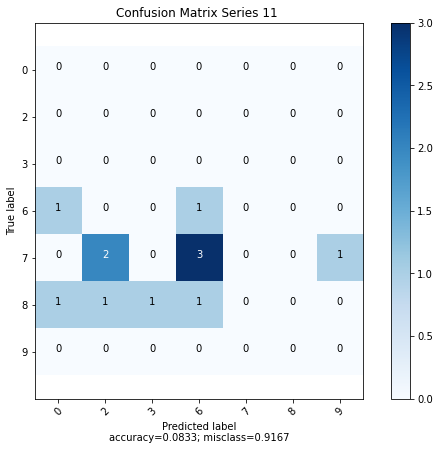

<Figure size 432x288 with 0 Axes>

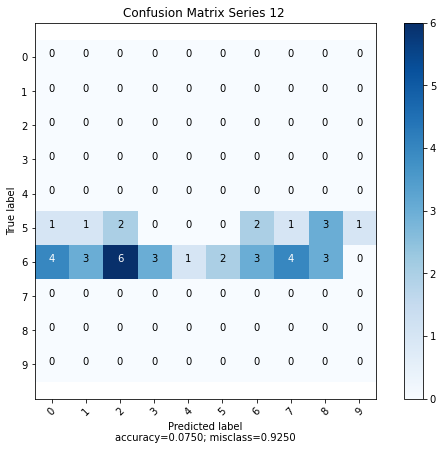

<Figure size 432x288 with 0 Axes>

In [ ]:
import sklearn.metrics as metrics
from functools import reduce
#serie 0
cm0 = metrics.confusion_matrix(y_true=test_array_s0, y_pred=pred_array_s0)
fig = plot_confusion_matrix(cm0,
                      target_names = reduce(np.union1d, (pred_array_s0, test_array_s0)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 0 ")
plt.savefig(os.path.join(path+'weights/CM_serie0_{}_{}.pdf'.format(immgs,cnn))) 

#serie 1
cm1 = metrics.confusion_matrix(y_true=test_array_s1, y_pred=pred_array_s1)
fig = plot_confusion_matrix(cm1,
                      target_names = reduce(np.union1d, (pred_array_s1, test_array_s1)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 1 ")
plt.savefig(os.path.join(path+'weights/CM_serie1_{}_{}.pdf'.format(immgs,cnn))) 

#serie 2
cm2 = metrics.confusion_matrix(y_true=test_array_s2, y_pred=pred_array_s2)
fig = plot_confusion_matrix(cm2,
                      target_names = reduce(np.union1d, (pred_array_s2, test_array_s2)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 2 ")
plt.savefig(os.path.join(path+'weights/CM_serie2_{}_{}.pdf'.format(immgs,cnn))) 

#serie 3
cm3 = metrics.confusion_matrix(y_true=test_array_s3, y_pred=pred_array_s3)
fig = plot_confusion_matrix(cm3,
                      target_names = reduce(np.union1d, (pred_array_s3, test_array_s3)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 3 ")
plt.savefig(os.path.join(path+'weights/CM_serie3_{}_{}.pdf'.format(immgs,cnn))) 

#serie 4
cm4 = metrics.confusion_matrix(y_true=test_array_s4, y_pred=pred_array_s4)
fig = plot_confusion_matrix(cm4,
                      target_names = reduce(np.union1d, (pred_array_s4, test_array_s4)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 4 ")
plt.savefig(os.path.join(path+'weights/CM_serie4_{}_{}.pdf'.format(immgs,cnn))) 

#serie 5
cm5 = metrics.confusion_matrix(y_true=test_array_s5, y_pred=pred_array_s5)
fig = plot_confusion_matrix(cm5,
                      target_names = reduce(np.union1d, (pred_array_s5, test_array_s5)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 5 ")
plt.savefig(os.path.join(path+'weights/CM_serie5_{}_{}.pdf'.format(immgs,cnn))) 

#serie 6
cm6 = metrics.confusion_matrix(y_true=test_array_s6, y_pred=pred_array_s6)
fig = plot_confusion_matrix(cm6,
                      target_names = reduce(np.union1d, (pred_array_s6, test_array_s6)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 6 ")
plt.savefig(os.path.join(path+'weights/CM_serie6_{}_{}.pdf'.format(immgs,cnn))) 

#serie 7
cm7 = metrics.confusion_matrix(y_true=test_array_s7, y_pred=pred_array_s7)
fig = plot_confusion_matrix(cm7,
                      target_names = reduce(np.union1d, (pred_array_s7, test_array_s7)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 7 ")
plt.savefig(os.path.join(path+'weights/CM_serie7_{}_{}.pdf'.format(immgs,cnn))) 

#serie 8
cm8 = metrics.confusion_matrix(y_true=test_array_s8, y_pred=pred_array_s8)
fig = plot_confusion_matrix(cm8,
                      target_names = reduce(np.union1d, (pred_array_s8, test_array_s8)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 8 ")
plt.savefig(os.path.join(path+'weights/CM_serie8_{}_{}.pdf'.format(immgs,cnn))) 

#serie 9 
cm9 = metrics.confusion_matrix(y_true=test_array_s9, y_pred=pred_array_s9)
fig = plot_confusion_matrix(cm9,
                      target_names = reduce(np.union1d, (pred_array_s9, test_array_s9)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 9 ")
plt.savefig(os.path.join(path+'weights/CM_serie9_{}_{}.pdf'.format(immgs,cnn))) 

#serie 10
cm10 = metrics.confusion_matrix(y_true=test_array_s10, y_pred=pred_array_s10)
fig = plot_confusion_matrix(cm10,
                      target_names = reduce(np.union1d, (pred_array_s10, test_array_s10)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 10 ")
plt.savefig(os.path.join(path+'weights/CM_serie10_{}_{}.pdf'.format(immgs,cnn))) 

#serie 11
cm11 = metrics.confusion_matrix(y_true=test_array_s11, y_pred=pred_array_s11)
fig = plot_confusion_matrix(cm11,
                      target_names = reduce(np.union1d, (pred_array_s11, test_array_s11)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 11 ")
plt.savefig(os.path.join(path+'weights/CM_serie11_{}_{}.pdf'.format(immgs,cnn))) 


cm12 = metrics.confusion_matrix(y_true=test_array_s12, y_pred=pred_array_s12)
fig = plot_confusion_matrix(cm12,
                      target_names = reduce(np.union1d, (pred_array_s12, test_array_s12)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 12 ")
plt.savefig(os.path.join(path+'weights/CM_serie12_{}_{}.pdf'.format(immgs,cnn))) 

## CRAMER V CORRELATION

In [ ]:
#PRIMA VERSIONE
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(y_test, y_pred)
print("cramer correlation tra predizioni delle classi, e le classi effettive")
cramer1 = cramers_v(confusion_matrix.values)
print(cramer1)

confusion_matrix2 = pd.crosstab(y_test_series, y_pred)
print("cramer correlation tra predizioni delle classi e le ground thruth di shotgun series")
cramer2 = cramers_v(confusion_matrix2.values)
print(cramer2)

cramer correlation tra predizioni delle classi, e le classi effettive
0.01109464181523855
cramer correlation tra predizioni delle classi e le ground thruth di shotgun series
0.0


In [ ]:
#SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo
contTable = pd.crosstab(y_test_series, y_pred)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(y_pred), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))


col_0  0  1   2   3  4  5   6  7  8  9
row_0                                 
0      1  3   6   3  1  4   4  2  2  0
1      5  5   6   4  1  1   4  2  1  1
2      6  1   9   3  2  2   9  3  2  1
3      6  6  12   6  2  5  10  6  5  0
4      5  8  14  11  6  8  17  7  7  3
5      1  0   3   2  0  1   2  1  3  1
6      4  2   6   3  7  3  10  5  1  1
7      4  5   6   5  1  3  13  8  3  0
8      0  0   3   1  0  1   2  0  1  0
9      0  1   3   2  0  0   4  4  0  0
10     0  2   0   1  1  1   3  0  0  0
11     2  0   3   1  0  0   5  0  0  1
12     5  4   8   3  1  2   5  5  6  1

                  Chi-square test  results
0  Pearson Chi-square ( 108.0) =   92.0518
1                      p-value =    0.8638
2                   Cramer's V =    0.1553

df = 9
V = 0.1553

quality classification of the correlation is:   medium


To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

## **T-SNE  & PCA**


### Spiegazioni, Link Utili e Implementazione 

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 

***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)


### Dataset 

In [ ]:
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx_complessivo.columns = ['ID','series', 'filename', 'class']
dataframe_dx_complessivo.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx_complessivo, dataframe_dx_complessivo]
result_complessivo = pd.concat(frames)
#print(result_complessivo)
#print(result_complessivo.loc[[1]])
#print(type(result_complessivo.loc[[1]]))

result_complessivo["class"] = result_complessivo["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result_complessivo["series"] = result_complessivo["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))
print(result_complessivo.loc[result_complessivo['class'] == '0'])
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo['class'] = pd.to_numeric(result_complessivo['class'], errors='coerce')
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo = result_complessivo.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result_complessivo[result_complessivo['class'].isnull()])

print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_NOPRE')
for index, row in result_complessivo.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result_complessivo = result_complessivo.drop(result_complessivo[(result_complessivo['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))

print('------------------- DATASET BASE ---------------')
print(type(result_complessivo))  
print(len(result_complessivo))
print(result_complessivo)

result_complessivo_totale = pd.DataFrame()

for index, row in result_complessivo.iterrows():
  filename_mask = 'mask_{}'.format(row['filename'])
  #filename_gray = 'gray_{}'.format(row['filename'])
  class_ = row['class']
  series_ = row['series']
  #print('{}_{}_{}_{}'.format(filename_gray,filename_mask, class_, series_)) "ID": row['ID']
  row_df_1 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_mask, "class" : class_},index=[0])
  #row_df_2 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_gray, "class" : class_},index=[0])
  #row_df_3 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename, "class" : class_},index=[0])
  #print(row_df_1)
  #print(row_df_2)
  result_complessivo_totale = result_complessivo_totale.append(row_df_1)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_2)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_3)


print('------------------- DATASET COMPLESSIVO ---------------') 
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
#print(result_complessivo_totale)

from sklearn.utils import shuffle
result_complessivo_totale = shuffle(result_complessivo_totale)
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
print(result_complessivo_totale)


### import utili per il TSNE e PCA

In [ ]:
%matplotlib inline
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd    
from sklearn.preprocessing import StandardScaler


### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - QUALITY CLASS

In [ ]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm
immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []

data_X = result_complessivo_totale['filename'][:1000] #---versione originale 
result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim ---versione originale 
y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... ---versione originale 


#-------------------------------------
# Qui secondo me tocca utilizzare il data loader ... altrimenti non va load_img è di Keras 
#-------------------------------------
for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    
    #print('Originale : {} x {} x {}'.format(image.size[0], image.size[1], len(image.size)-1))
    #plt.imshow(image)
    scale_percent = 90 # percent of original size
    width, height = image.size
    #print('channel : {}'.format(len(image.size)))
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X = np.asarray(imgs_array_tot)
print(X.shape)


##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - SHOTGUN SERIES

In [ ]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm

immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []
data_X = result_complessivo_totale['filename'][:1000]

result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim

y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... 

y_series = result_complessivo_totale['series'][:1000] #--- deve essere uguale ...

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")

    scale_percent = 90 # percent of original size
    width, height = image.size
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X2 = np.asarray(imgs_array_tot)
print(X2.shape) 

#### Check & Create Dataframe for PCA (Principal Analysis Component) & T-SNE (t-distributed stochastic neighbor embedding)

##### classi di qualità 

In [ ]:
print('X SHAPE : {}'.format(X.shape))

nsamples = X.shape[0]
rows = X.shape[1]
cols = X.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X))
X_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente 

feat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df = pd.DataFrame(X_1,columns=feat_cols)
#df = pd.DataFrame(X_1)
df['y'] = pd.DataFrame({ 'y': np.array(y) })
df['label'] = df['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])


##### shotgun series 

In [ ]:
print('X2 SHAPE : {}'.format(X2.shape))

nsamples = X2.shape[0]
rows = X2.shape[1]
cols = X2.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X2))
X_11 = np.reshape(X2, (X2.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_11.shape)) #--- controllo se ho fatto tutto correttamente 
#print(X_1)

feat_cols = [ 'pixel'+str(i) for i in range(X_11.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df_2 = pd.DataFrame(X_11,columns=feat_cols)
#df = pd.DataFrame(X_1)
df_2['y'] = pd.DataFrame({ 'y': np.array(y_series) })
df_2['label'] = df_2['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df_2.shape))



# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_2.shape[0])


#### Calcolo TSNE & PLOT TSNE

##### TSNE QUALITY CLASS

In [ ]:
time_start = time.time()
N = 1000 
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale 
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

##### TSNE SHOTGUN SERIES 

In [ ]:
time_start = time.time()
N = 1000
df_subset_series = df_2.loc[rndperm[:N],:].copy()
#data_subset_series = df_subset_series
data_subset_series = df_subset_series[feat_cols].values
#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results_series = tsne_series.fit_transform(data_subset_series)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

##### PLOT TSNE QUALITY CLASSES

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)

##### TSNE PLOT SHOTGUN SERIES 

In [ ]:
df_subset_series['tsne-2d-one'] = tsne_results_series[:,0]
df_subset_series['tsne-2d-two'] = tsne_results_series[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset_series,
    legend="full",
    alpha=0.3
)

## **Metriche Nuove**

## Alcune Definizioni 
*  **True Positives** (TP): Items where the true label is positive and whose class is correctly predicted to be positive.
*  **False Positives** (FP): Items where the true label is negative and whose class is incorrectly predicted to be positive
*  **True Negatives** (N): Items where the true label is negative and whose class is correctly predicted to be negative.
*  **False Negatives** (FN): Items where the true label is positive and whose class is incorrectly predicted to be negative.

* **False Positive Rate**, or *Type I Error*: Number of items wrongly identified as positive out of the total actual negatives — FP/(FP+TN) - This error means that an image not containing a particular parasite egg is incorrectly labeled as having it
* **False Negative Rate**, or *Type II Error*: Number of items wrongly identified as negative out of the total actual positives — FN/(FN+TP). This metric is especially important to us, as it tells us the frequency with which a particular parasite egg is not classified correctly

-------------

* **Statistical Parity Difference**
This measure is based on the following formula :
𝑃𝑟(𝑌=1|𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑)−𝑃𝑟(𝑌=1|𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑) Here the bias or statistical imparity is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1. So it has to be close to 0 so it will be fair.

*  **Equal Opportunity Difference** This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula - 𝑇𝑃𝑅𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑−𝑇𝑃𝑅𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑 Same as the previous metric we need it to be close to 0.

* **demographic parity** A fairness metric that is satisfied if the results of a model's classification are not dependent on a given sensitive attribute.

* **equality of opportunity** A fairness metric that checks whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute. In other words, equality of opportunity measures whether the people who should qualify for an opportunity are equally likely to do so regardless of their group membership.

In [ ]:
!pip install fairlearn 
from fairlearn.metrics import selection_rate
from fairlearn.metrics import true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate
from fairlearn.metrics import equalized_odds_difference

import sklearn as sk


#---- metriche lisa ----#
y_true = test_balance_df['class'].to_numpy()
SR = selection_rate(y_true, y_pred, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##---- Link Riccardo ----##
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


Balanced_Accuracy = sk.metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
print('Balanced Accuracy Generale : {}' . format(Balanced_Accuracy))


#####----------- PER CIASCUNA SERIE BALANCED ACCURACY -----------####

Balanced_Accuracy_s0= sk.metrics.balanced_accuracy_score(test_array_s0, pred_array_s0, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 0 : {}' . format(Balanced_Accuracy_s0))

Balanced_Accuracy_s1= sk.metrics.balanced_accuracy_score(test_array_s1, pred_array_s1, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 1 : {}' . format(Balanced_Accuracy_s1))

Balanced_Accuracy_s2= sk.metrics.balanced_accuracy_score(test_array_s2, pred_array_s2, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 2 : {}' . format(Balanced_Accuracy_s2))

Balanced_Accuracy_s3= sk.metrics.balanced_accuracy_score(test_array_s3, pred_array_s3, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 3 : {}' . format(Balanced_Accuracy_s3))

Balanced_Accuracy_s4= sk.metrics.balanced_accuracy_score(test_array_s4, pred_array_s4, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 4 : {}' . format(Balanced_Accuracy_s4))

Balanced_Accuracy_s5= sk.metrics.balanced_accuracy_score(test_array_s5, pred_array_s5, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 5 : {}' . format(Balanced_Accuracy_s5))

Balanced_Accuracy_s6= sk.metrics.balanced_accuracy_score(test_array_s6, pred_array_s6, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 6 : {}' . format(Balanced_Accuracy_s6))

Balanced_Accuracy_s7= sk.metrics.balanced_accuracy_score(test_array_s7, pred_array_s7, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 7 : {}' . format(Balanced_Accuracy_s7))

Balanced_Accuracy_s8= sk.metrics.balanced_accuracy_score(test_array_s8, pred_array_s8, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 8 : {}' . format(Balanced_Accuracy_s8))

Balanced_Accuracy_s9= sk.metrics.balanced_accuracy_score(test_array_s9, pred_array_s9, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 9 : {}' . format(Balanced_Accuracy_s9))

Balanced_Accuracy_s10= sk.metrics.balanced_accuracy_score(test_array_s10, pred_array_s10, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 10 : {}' . format(Balanced_Accuracy_s10))

Balanced_Accuracy_s11= sk.metrics.balanced_accuracy_score(test_array_s11, pred_array_s11, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 11 : {}' . format(Balanced_Accuracy_s11))

Balanced_Accuracy_s12= sk.metrics.balanced_accuracy_score(test_array_s12, pred_array_s12, sample_weight=None, adjusted=False)
print('Balanced Accuracy Series 12 : {}' . format(Balanced_Accuracy_s12))

#----------- MEDIA DELLE BALANCED ACCURACY ---------------
Sum = Balanced_Accuracy_s0 + Balanced_Accuracy_s1 + Balanced_Accuracy_s2 + Balanced_Accuracy_s3 + Balanced_Accuracy_s4 + Balanced_Accuracy_s5 + Balanced_Accuracy_s6 + Balanced_Accuracy_s7 + Balanced_Accuracy_s8 + Balanced_Accuracy_s9 + Balanced_Accuracy_s10 + Balanced_Accuracy_s11 + Balanced_Accuracy_s12 
Average = Sum/12
print('Average Balanced Accuracy : {}' . format(Average))
 

##---- Wodsworth et Al ----# 
#HIGH_RISK_GAP = SP #modulo o cardinalità 

#FN_GAP = false_negative (s1) - false negative (s2) 
#FN_GAP = (false_negative_rate(y_true, y_pred) - false_negative_rate(y_true, y_pred))  #modulo o cardinalità
  
#FN_GAP = false_negative (s1) - false negative (s2) 
#FP_GAP = (false_positive_rate(y_true, y_pred) - false_positive_rate(y_true, y_pred))  #modulo o cardinalità



### LINK UTILE ####
#https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

     |████████████████████████████████| 177 kB 5.2 MB/s 
selection_rate : 0.08726415094339622
TPR : [0.13513514 0.         0.15789474 0.10714286 0.17142857 0.078125
 0.14492754 0.04651163 0.0625     0.        ]
TNR : [0.9121447  0.9038961  0.81088083 0.89393939 0.95886889 0.92777778
 0.78028169 0.89238845 0.92553191 0.97755611]
PPV : [0.12820513 0.         0.07594937 0.06666667 0.27272727 0.16129032
 0.11363636 0.04651163 0.09677419 0.        ]
NPV : [0.91688312 0.89922481 0.90724638 0.93403694 0.9278607  0.84987277
 0.82440476 0.89238845 0.88549618 0.94457831]
FPR : [0.0878553  0.0961039  0.18911917 0.10606061 0.04113111 0.07222222
 0.21971831 0.10761155 0.07446809 0.02244389]
FNR : [0.86486486 1.         0.84210526 0.89285714 0.82857143 0.921875
 0.85507246 0.95348837 0.9375     1.        ]
FDR : [0.87179487 1.         0.92405063 0.93333333 0.72727273 0.83870968
 0.88636364 0.95348837 0.90322581 1.        ]
Accuracy : [0.84433962 0.82075472 0.75235849 0.84198113 0.89386792 0.7995283


##PROVA MDSS (ATTUALMENTE NON FUNZIONA)

In [ ]:
'''imports'''
'''Importing packages & libraries for Bias metrics from AIF360 (end page analysis)'''

"""
import sys
import itertools
import datetime

### altri package necessari 
!pip install tempeh -q --force-reinstall
!pip install fairlearn -q --force-reinstall
!pip install GitPython -q --force-reinstall

#download aif360 
#!pip install -r requirement.txt 
#!python setup.py
###test  errore nella foto 

#!pip uninstall scikit-learn -q -y 
# errore cercato in rete : https://github.com/pycaret/pycaret/issues/704
# INSTALL CONDA ON GOOGLE COLAB
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
# INSTALL PACKAGE CON CONDA 
#!conda install -c conda-forge scikit-learn -y 

## package necessario utile per il gitclone
from git import Repo

date_ = datetime.datetime.now()
#Repo.clone_from("link ... .git", "path di salvataggio")
#Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360_repo_{}".format(date_))
Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360") #controllare sempre, se è già salvato ... se salvato basta commentarlo

#---serve per aggiungere un nuovo package alla lista dei package installati
sys.path.append('/content/aif360/')


from aif360.metrics.mdss.ScoringFunctions import Bernoulli, ScoringFunction 
from aif360.metrics.mdss import MDSS

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix

from IPython.display import Markdown, display
import numpy as np
import pandas as pd

from collections import defaultdict
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
"""

In [ ]:
"""from aif360.datasets import StandardDataset
dataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],
                 protected_attribute_names=['sex', 'race'],
                 privileged_classes=[[1], [1]],
                 instance_weights_name=None)"""

In [ ]:
"""
# !python3 -m pip install <pkg> -q il -q è per il quiet (per non avere quel macello in output) --force-reinstall

#https://github.com/Trusted-AI/AIF360
'''REPOSITORY PRINCIPALE DOVE SI TROVANO TUTTE LE RESTANTI CARTELLE E IMPLEMENTAZIONI'''
#https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_mdss_classifier_metric.ipynb
'''file dove il tipo fa un esempio di uso di questa metrica!'''
#https://aif360.readthedocs.io/en/latest/index.html
'''link di aif360 dove ci sono i metodi CHE IMPORTA SOTTO'''


class MDSSClassificationMetric(ClassificationMetric):
    '''
        Bias subset scanning is proposed as a technique to identify bias in predictive models using subset scanning [1].
        This class is a wrapper for the bias scan scoring and scanning methods that uses the ClassificationMetric abstraction.
    References:
        .. [1] Zhang, Z., & Neill, D. B. (2016). Identifying significant predictive bias in classifiers. arXiv preprint arXiv:1611.08292.
    '''
    def __init__(self, dataset: BinaryLabelDataset, classified_dataset: BinaryLabelDataset, 
                scoring_function: ScoringFunction = Bernoulli(direction='positive'), unprivileged_groups: dict = None, privileged_groups:dict = None):
    
        super(MDSSClassificationMetric, self).__init__(dataset, classified_dataset,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
        
        self.scanner = MDSS(scoring_function)
    
    def score_groups(self, privileged=True, penalty = 1e-17):
        '''
        compute the bias score for a prespecified group of records.
        
        :param privileged: flag for group to score - privileged group (True) or unprivileged group (False).
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the score for the group
        '''
        groups = self.privileged_groups if privileged else self.unprivileged_groups
        subset = dict()
        
        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'

        for g in groups:
            for k, v in g.items():
                if k in subset.keys():
                    subset[k].append(v)
                else:
                    subset[k] = [v]
        
        coordinates = pd.DataFrame(self.dataset.features, columns=self.dataset.feature_names)
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        self.scanner.scoring_function.kwargs['direction'] = direction
        return self.scanner.score_current_subset(coordinates, expected, outcomes, dict(subset), penalty)
    
    def bias_scan(self, privileged=True, num_iters = 10, penalty = 1e-17):
        '''
        scan to find the highest scoring subset of records
        
        :param privileged: flag for group to scan for - privileged group (True) or unprivileged group (False). 
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param num_iters: number of iterations (random restarts)
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the highest scoring subset and the score
        '''

        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'
        self.scanner.scoring_function.kwargs['direction'] = direction

        coordinates = pd.DataFrame(self.classified_dataset.features, columns=self.classified_dataset.feature_names)
        
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        return self.scanner.scan(coordinates, expected, outcomes, penalty, num_iters)

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

#import requests
#url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
#r = requests.get(url, allow_redirects=True)
#open('dataset.csv', 'wb').write(r.content)
#dataset_orig = pd.read_csv('/content/dataset.csv', sep=",")  


series_group = [{'series': 0, 'series': 1, 'series': 2, 'series': 3, 'series': 4, 'series': 5, 'series': 6, 'series': 7, 'series': 8, 'series': 9, 'series': 10, 'series': 11, 'series': 12}]
classes_group = [{'class': 0, 'class': 1, 'class': 2, 'class': 3, 'class': 4, 'class': 5, 'class': 6, 'class': 7, 'class': 8, 'class': 9}]

"""



In [ ]:
"""

mdss_classified = MDSSClassificationMetric(dataset_orig_test, dataset_bias_test,
                         unprivileged_groups=male_group,
                         privileged_groups=female_group)


mdss_classified = MDSSClassificationMetric(test_balance_df, dataset_bias_test,
                         unprivileged_groups=classes_group,
                         privileged_groups=series_group)

series_privileged_score = mdss_classified.score_groups(privileged=True)
print(series_privileged_score)
"""